In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# apply some styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [3]:
weather_df = pd.read_csv('cleaned_weather.csv')
# read the solar plant generation data
solar_df = pd.read_csv('plant_output.csv')
# drop unused columns
solar_df = solar_df.drop(['Plant', 'Real-time power(kW)', 'Daily feed-in energy(kWh)', 'Energy purchased today(kWh)'], axis=1)

# Both weather and solar df are date aligned
data_df = weather_df
data_df['output'] = solar_df['Daily yield(kWh)']
# Remove entries with known 0 output
data_df = data_df[~(data_df['output'] == 0)]
data_df.drop(data_df.columns[0], axis=1, inplace=True)

/var/folders/zh/nt4cvtjd1bl_ntm3_d6kztf40000gn/T/ipykernel_75133/720678684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop(data_df.columns[0], axis=1, inplace=True)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df = data_df[numeric_cols]
data_df = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_df.head(5)

,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,-1.403946,-0.829721,-1.376138,0.242118,1.004365,-0.293308,-0.6003,-0.451987,-0.883851,-0.680943,-0.651917,-1.509529,-0.281256
1,-0.916350,-1.188969,-1.340224,-0.316047,0.483319,-0.293308,-0.6003,-0.451987,-0.686336,-0.583275,-0.588037,-1.502480,-0.042159
2,-1.322680,-1.787716,-1.735276,-1.127923,0.024799,-0.293308,-0.6003,-0.451987,0.044818,-0.513248,-0.502863,-1.495189,0.017616
3,-1.187236,-2.296651,-2.094413,-1.584603,-0.301724,-0.293308,-0.6003,-0.451987,-0.859595,-0.476393,-0.460277,-1.487654,-0.639903
4,-1.105970,-1.997277,-1.843017,-1.178665,-0.114147,-0.293308,-0.6003,-0.451987,-0.280909,-0.588803,-0.566744,-1.479148,-0.460580


In [5]:
# Split data 
X = data_df.drop('output', axis=1)
y = data_df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print( 'X ', X.shape)
print( 'y ', y.shape)
print( 'X_train ', X_train.shape)
print( 'y_train ', y_train.shape)

X  (151, 12)
y  (151,)
X_train  (120, 12)
y_train  (120,)


In [6]:
def predict_and_eval(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    tr_mse = mean_squared_error(y_train, y_train_pred)
    tr_r2 = r2_score(y_train, y_train_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train Mean Squared Error: {tr_mse}")
    print(f"Train R-squared: {tr_r2}")

    print(f"Test Mean Squared Error: {mse}")
    print(f"Test R-squared: {r2}")

    metrics = {
        'train_mse' : tr_mse,
        'train_r2' : tr_r2,
        'test_mse' : mse,
        'test_r2' : r2
        }

    return metrics, y_train_pred, y_test_pred

In [7]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError

2025-07-07 14:57:00.497676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def build_model():
    tf.random.set_seed(32)
    model = Sequential([
        Input(shape=(12,)),
        tf.keras.layers.Normalization(axis=None),
        #tf.keras.layers.Dropout(rate=0.1),
        Dense(units=128, activation='relu', name='layer0'),
        tf.keras.layers.Dropout(rate=0.1),
        Dense(units=64, activation='relu', name='layer1'),
        Dense(units=16, activation='relu', name='layer2'),
        Dense(units=1, activation='linear', name='output'),
        ])
    model.summary()
    return model

def build_reg_model():
    tf.random.set_seed(32)
    reg_rate = 0.1
    model = Sequential([
        Input(shape=(12,)),
        tf.keras.layers.Normalization(axis=None),
        #tf.keras.layers.Dropout(rate=0.1),
        Dense(units=128, activation='relu', name='layer0'), # kernel_regularizer=tf.keras.regularizers.l2(reg_rate)),
        #tf.keras.layers.Dropout(rate=0.1),
        Dense(units=64, activation='relu', name='layer1', kernel_regularizer=tf.keras.regularizers.l2(reg_rate)),
        Dense(units=16, activation='relu', name='layer2', kernel_regularizer=tf.keras.regularizers.l2(reg_rate)),
        Dense(units=1, activation='linear', name='output'),
        ])
    model.summary()
    return model

def train_model(model, X_train, y_train, epcs = 100):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=MeanSquaredError())
    history = model.fit(X_train, y_train, epochs=epcs, verbose=0)
    nn_metrics, nn_y_train_pred, nn_y_test_pred = predict_and_eval(model, X_train, y_train, X_test, y_test)
    return nn_metrics, nn_y_test_pred



In [16]:
model = build_model()
max_iters = 10
for i in range (max_iters):
    data_shuffled = data_df
    #data_shuffled = data_df.sample(frac=1).reset_index(drop=True)
    X = data_shuffled.drop('output', axis=1)
    y = data_shuffled['output']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    nn_metrics, nn_y_test_pred = train_model(model, X_train, y_train, 50)
    print('==== Iter: ', i, nn_metrics, ' ====')
    if nn_metrics['test_r2'] > 0.7:
        break

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 12)             │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer0 (Dense)                  │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980 (42.89 KB)

 Trainable params: 10,977 (42.88 KB)

 Non-trainable params: 3 (16.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Train Mean Squared Error: 0.18856481228466032
Train R-squared: 0.825794788866084
Test Mean Squared Error: 0.534805950421895
Test R-squared: 0.21081333743255792
==== Iter:  0 {'train_mse': 0.18856481228466032, 'train_r2': 0.825794788866084, 'test_mse': 0.534805950421895, 'test_r2': 0.21081333743255792}  ====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Train Mean Squared Error: 0.1513301030811455
Train R-squared: 0.8601939978156105
Test Mean Squared Error: 0.5127585814471726
Test R-squared: 0.24334754825393756
==== Iter:  1 {'train_mse': 0.1513301030811455, 'train_r2': 0.8601939978156105, 'test_mse': 0.5127585814471726, 'test_r2': 0.24334754825393756}  ====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Train Mean Squared Error: 0.1344049369933245
Train R-squared: 0.8758302774378892
Test Mean Squared Error: 0.49571742596668716
Test R-squared: 0.26849433

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5994


0.5993771553039551

In [19]:
compare_df = pd.DataFrame(y_test)
compare_df['pred'] = nn_y_test_pred
compare_df.head(10)

,output,pred
40,-0.460580,-0.087019
147,0.615360,-0.584375
38,-0.550241,-0.547882
132,-2.492910,-2.123260
144,-2.044602,-2.754731
99,0.794683,0.595246
83,0.555585,0.452864
39,-0.699677,-0.325339
136,-0.101933,-1.618158
23,-0.400805,-0.781052


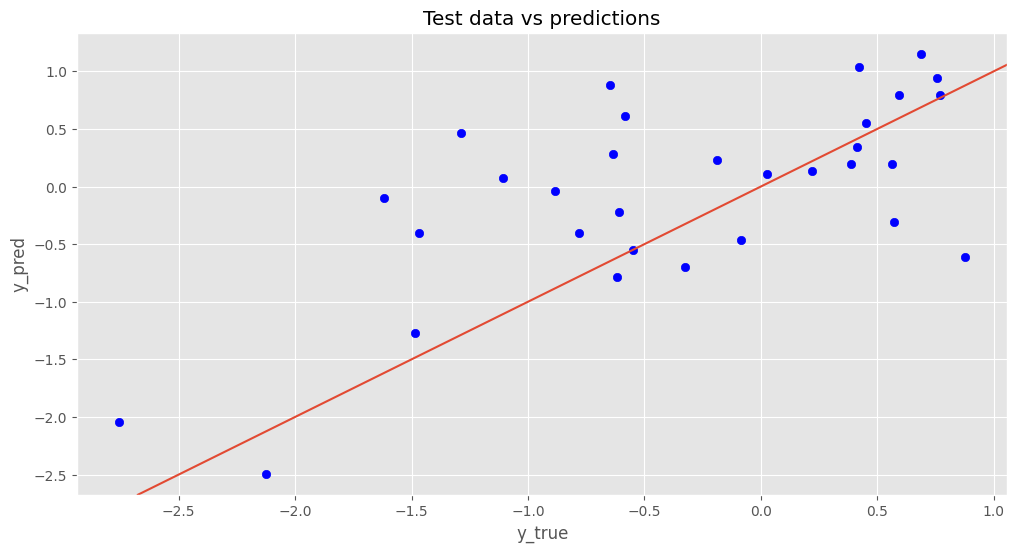

In [20]:
plt.scatter(nn_y_test_pred, y_test,c= 'blue')
ax = plt.subplot()
ax.axline((0, 0), slope=1)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Test data vs predictions')
plt.show()

### Observations
1. Multiple training rounds help improve the accuracy
2. Shuffling the dataset also allow better learning - even with fewer epochs. In this case though, the test dataset is not entirely new to the model. 
3. A R2 scores of > 70% for both training and test dataset is acheived with this NN. The NN model shows better balance of accuracy compared to Ridge or LassoCV regression models
4. Best R2 score seen with NN model
```
Train Mean Squared Error: 2.874224244599256
Train R-squared: 0.7230831100524593
Test Mean Squared Error: 3.124005194617189
Test R-squared: 0.777090053517122
```


In [63]:
reg_model = build_reg_model()
max_iters = 2
for i in range (max_iters):
    #data_shuffled = data_df
    data_shuffled = data_df.sample(frac=1).reset_index(drop=True)
    X = data_shuffled.drop('output', axis=1)
    y = data_shuffled['output']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    nn_metrics, nn_y_test_pred = train_model(reg_model, X_train, y_train, 50)
    print('==== Iter: ', i, nn_metrics, ' ====')
    if nn_metrics['test_r2'] > 0.7:
        break

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_12                │ (None, 12)             │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer0 (Dense)                  │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980 (42.89 KB)

 Trainable params: 10,977 (42.88 KB)

 Non-trainable params: 3 (16.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Train Mean Squared Error: 0.33493467045436864
Train R-squared: 0.6951054293131292
Test Mean Squared Error: 0.18882573633648797
Test R-squared: 0.6594151575744416
==== Iter:  0 {'train_mse': 0.33493467045436864, 'train_r2': 0.6951054293131292, 'test_mse': 0.18882573633648797, 'test_r2': 0.6594151575744416}  ====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Train Mean Squared Error: 0.21170160362433357
Train R-squared: 0.7663029647916367
Test Mean Squared Error: 0.6307626626569036
Test R-squared: 0.498257607706733
==== Iter:  1 {'train_mse': 0.21170160362433357, 'train_r2': 0.7663029647916367, 'test_mse': 0.6307626626569036, 'test_r2': 0.498257607706733}  ====


In [64]:
reg_model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.7242


0.7241790294647217

In [65]:
reg_compare_df = pd.DataFrame(y_test)
reg_compare_df['pred'] = nn_y_test_pred
reg_compare_df.head(10)

,output,pred
40,-0.101933,-0.033298
147,-1.954940,-0.021445
38,0.465924,0.374514
132,0.107277,-0.217738
144,-0.400805,-0.166576
99,0.495811,0.831876
83,0.555585,0.276757
39,-2.313586,-1.389976
136,-3.090654,-0.168308
23,0.884345,0.007917


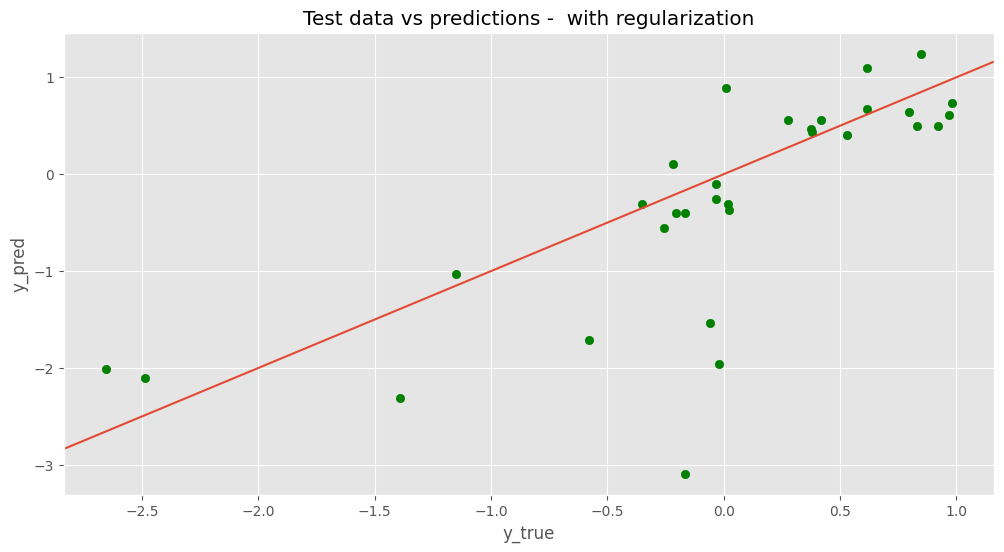

In [66]:
plt.scatter(nn_y_test_pred, y_test,c= 'green')
ax = plt.subplot()
ax.axline((0, 0), slope=1)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Test data vs predictions -  with regularization')
plt.show()

In [134]:
# It seems the the RandomForestRegressor model have high bias(underfitting). Let's try adding more features using PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly  = poly.fit_transform(X)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2, random_state=32)

print( 'X_poly ', X_poly.shape)
print( 'X_poly_train ', X_poly_train.shape)
print( 'X_poly_test ', X_poly_train.shape)

input_shape = X_poly_train.shape[1]

X_poly  (151, 78)
X_poly_train  (120, 78)
X_poly_test  (120, 78)


In [161]:
def build_poly_model():
    tf.random.set_seed(32)
    reg_rate = 0.01
    model = Sequential([
        Input(shape=(input_shape,)),
        tf.keras.layers.Normalization(axis=None),
        tf.keras.layers.Dropout(rate=0.2),
        Dense(units=128, activation='relu', name='layer0'), # kernel_regularizer=tf.keras.regularizers.l2(reg_rate)),
        tf.keras.layers.Dropout(rate=0.1),
        Dense(units=64, activation='relu', name='layer1',   kernel_regularizer=tf.keras.regularizers.l2(reg_rate)),
        #tf.keras.layers.Dropout(rate=0.1),
        Dense(units=16, activation='relu', name='layer2', kernel_regularizer=tf.keras.regularizers.l2(reg_rate)),
        Dense(units=1, activation='linear', name='output'),
        ])
    model.summary()
    return model

In [162]:
poly_model = build_poly_model()
poly_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=MeanSquaredError())
history = poly_model.fit(X_poly_train, y_train, epochs=500, verbose=0)
nn_poly_metrics, nn_poly_y_train_pred, nn_poly_y_test_pred = predict_and_eval(poly_model, X_poly_train, y_train, X_poly_test, y_test)
print('==== Metrics: ', nn_poly_metrics, ' ====')

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_64                │ (None, 78)             │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 78)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer0 (Dense)                  │ (None, 128)            │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,428 (75.89 KB)

 Trainable params: 19,425 (75.88 KB)

 Non-trainable params: 3 (16.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Train Mean Squared Error: 0.14538769730552115
Train R-squared: 0.8395067716333262
Test Mean Squared Error: 2.4013077239632565
Test R-squared: -0.9101287273070293
==== Metrics:  {'train_mse': 0.14538769730552115, 'train_r2': 0.8395067716333262, 'test_mse': 2.4013077239632565, 'test_r2': -0.9101287273070293}  ====


### Observations after using polynomial features
- Adding polynomial features doesn't help with test R2 score. The model exhibits high variance.
- Adding regularization to the layers helps lower the training error but it doesn't necessarily improve test error.